# **Preprocessing Berita (cnbcindonesia.com), Summarization & Modeling With Graph Cosine Similirity and Closeness Centrality**

## Import Library

1. **Preprocessing Berita**:
   - Kode ini dimulai dengan mengimpor berbagai pustaka yang diperlukan, termasuk NLTK (Natural Language Toolkit) untuk tokenisasi dan pengunduhan data bahasa alami, serta pustaka-pustaka Scikit-Learn dan NetworkX untuk pemrosesan dan analisis data.
   - Pustaka `warnings` digunakan untuk mengabaikan peringatan selama eksekusi.
   - Data teks berita akan diproses melalui tahap-tahap seperti tokenisasi, membersihkan tanda baca, dan penghapusan kata-kata umum (stop words) agar lebih mudah untuk dianalisis.

2. **Ekstraksi Fitur**:
   - Pustaka `TfidfVectorizer` digunakan untuk menghasilkan representasi Term Frequency-Inverse Document Frequency (TF-IDF) dari teks berita. Ini adalah cara untuk mengukur seberapa penting suatu kata dalam dokumen tersebut dibandingkan dengan seluruh korpus dokumen.
   - Fitur-fitur TF-IDF akan digunakan dalam analisis berikutnya.

3. **Pemodelan & Evaluasi**:
   - Kode ini mengimpor modul-model Machine Learning seperti Naive Bayes (`GaussianNB`) dan Support Vector Machine (`SVC`) dari Scikit-Learn.
   - Data dibagi menjadi subset pelatihan dan pengujian menggunakan `train_test_split` untuk melatih model dan mengukur kinerjanya.
   - Metrik evaluasi seperti akurasi, laporan klasifikasi, dan matriks kebingungan digunakan untuk mengukur kinerja model.
   - Selain itu, NetworkX digunakan untuk menghasilkan grafik dan visualisasi data, seperti grafik kosinusa untuk mengukur kesamaan dokumen.
   - Hasil akhir dari analisis ini adalah model yang melatih data berita dan dapat digunakan untuk klasifikasi, serta metrik evaluasi yang membantu dalam memahami kinerja model tersebut.

In [16]:
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import nltk
import re
import joblib

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Dataset

In [17]:
df = pd.read_csv('/content/drive/MyDrive/Kuliah /Semester 7/Pencarian Dan Penambangan Web/ppw/Dataset/Data Berita CNBC.csv')
df

,Url,Judul,Tanggal,Author,Artikel,Category
0,https://www.cnbcindonesia.com/tech/20231106180...,Astronom Yakin Alien Sudah Tahu di Bumi Ada Ma...,06 November 2023 19:50,"Intan Rakhmayanti Dewi, CNBC Indonesia","Jakarta, CNBC Indonesia - Astronom yakin alien...",Tech
1,https://www.cnbcindonesia.com/tech/20231106175...,Scarlett Johansson Ngamuk Wajah dan Suaranya D...,06 November 2023 19:00,"Intan Rakhmayanti Dewi, CNBC Indonesia","Jakarta, CNBC Indonesia - Aktrisnominasi Oscar...",Tech
2,https://www.cnbcindonesia.com/tech/20231106164...,"Dulu Bikin Ghozali Kaya Raya, Startup Ini Peca...",06 November 2023 18:20,"Novina Putri Bestari, CNBC Indonesia","Jakarta, CNBC Indonesia - Masih ingat Ghozali ...",Tech
3,https://www.cnbcindonesia.com/tech/20231106162...,"Jeff Bezos Pindah ke Rumah Rp 2,3 T Demi Pacar...",06 November 2023 17:40,"Novina Putri Bestari, CNBC Indonesia","Jakarta, CNBC Indonesia - Jeff Bezos memutuska...",Tech
4,https://www.cnbcindonesia.com/tech/20231106172...,BRIBRAIN Sukses Raih Penghargaan Ini di IDC Aw...,06 November 2023 17:33,"Khoirul Anam, CNBC Indonesia","Jakarta, CNBC Indonesia- PT Bank Rakyat Indone...",Tech
...,...,...,...,...,...,...
1495,https://www.cnbcindonesia.com/entrepreneur/202...,"Bisnis Kopi Meluas, Kompetisi Barista dan Latt...",03 April 2023 12:41,"Zefanya Aprilia, CNBC Indonesia","Jakarta, CNBCIndonesia -Roadshow Bezzera Latte...",Entrepreneur
1496,https://www.cnbcindonesia.com/entrepreneur/202...,"Rahusna, Alumni ITB Penemu Mesin Pemilah Sampa...",03 April 2023 12:33,"Mentari Puspadini, CNBC Indonesia","Jakarta, CNBC Indonesia - Hingga saat ini, per...",Entrepreneur
1497,https://www.cnbcindonesia.com/entrepreneur/202...,Pameran Barang Mewah Terbesar akan Hadir di RI...,31 March 2023 12:45,"Zefanya Aprilia, CNBC Indonesia","Jakarta, CNBCIndonesia -Indonesia akan menyele...",Entrepreneur
1498,https://www.cnbcindonesia.com/entrepreneur/202...,SETC & INOTEK Kerja Sama Gelar Pelatihan UMKM ...,31 March 2023 09:30,"Teti Purwanti, CNBC Indonesia","Jakarta, CNBC Indonesia - Sampoerna Entreprene...",Entrepreneur


## 1. Cleaning Data

### Menghapus Data Null

Kode ini memeriksa dan mengatasi data yang hilang (NaN) dalam DataFrame `df`. Data yang hilang dihapus dari DataFrame menggunakan `df.dropna()`.


In [18]:
df.isnull().sum()

Url         0
Judul       0
Tanggal     0
Author      0
Artikel     0
Category    0
dtype: int64

In [19]:
df = df.dropna()
df.isnull().sum()

Url         0
Judul       0
Tanggal     0
Author      0
Artikel     0
Category    0
dtype: int64

In [20]:
df.shape

(1500, 6)

### Menghapus Karakter Tertentu

Fungsi `cleaning` digunakan untuk membersihkan teks dalam kolom 'Abstrak'. Ini menghapus karakter-karakter yang tidak relevan seperti tanda baca dan mengubah teks menjadi daftar kata-kata.

In [21]:
def cleaning(text):
  text = re.sub(r'[^\w\s.?!,]', '', text).strip()
  return text

df['Cleaning'] = df['Artikel'].apply(cleaning)
df['Cleaning']

0       Jakarta, CNBC Indonesia  Astronom yakin alien ...
1       Jakarta, CNBC Indonesia  Aktrisnominasi Oscar,...
2       Jakarta, CNBC Indonesia  Masih ingat Ghozali y...
3       Jakarta, CNBC Indonesia  Jeff Bezos memutuskan...
4       Jakarta, CNBC Indonesia PT Bank Rakyat Indones...
                              ...                        
1495    Jakarta, CNBCIndonesia Roadshow Bezzera Latte ...
1496    Jakarta, CNBC Indonesia  Hingga saat ini, perm...
1497    Jakarta, CNBCIndonesia Indonesia akan menyelen...
1498    Jakarta, CNBC Indonesia  Sampoerna Entrepreneu...
1499    Jakarta, CNBC Indonesia  Masalah postur tubuh ...
Name: Cleaning, Length: 1500, dtype: object

In [22]:
def tokenizer(text):
  text = text.lower()
  return sent_tokenize(text)

df['Tokenizing'] = df['Cleaning'].apply(tokenizer)
df['Tokenizing']

0       [jakarta, cnbc indonesia  astronom yakin alien...
1       [jakarta, cnbc indonesia  aktrisnominasi oscar...
2       [jakarta, cnbc indonesia  masih ingat ghozali ...
3       [jakarta, cnbc indonesia  jeff bezos memutuska...
4       [jakarta, cnbc indonesia pt bank rakyat indone...
                              ...                        
1495    [jakarta, cnbcindonesia roadshow bezzera latte...
1496    [jakarta, cnbc indonesia  hingga saat ini, per...
1497    [jakarta, cnbcindonesia indonesia akan menyele...
1498    [jakarta, cnbc indonesia  sampoerna entreprene...
1499    [jakarta, cnbc indonesia  masalah postur tubuh...
Name: Tokenizing, Length: 1500, dtype: object

## Graph Cosine Similirity

Fungsi `graph_cosine_sim` digunakan untuk membuat grafik jaringan (graph) yang mencerminkan hubungan kesamaan (cosine similarity) antara kalimat dalam teks. Berikut adalah penjelasan singkat tentang apa yang dilakukan fungsi ini:

1. **Penggunaan TF-IDF**: Pertama, fungsi ini menggunakan `TfidfVectorizer` untuk menghitung representasi Term Frequency-Inverse Document Frequency (TF-IDF) dari teks yang diberikan (daftar `x` yang berisi kalimat-kalimat). Ini mengukur pentingnya kata-kata dalam kalimat relatif terhadap seluruh teks.

2. **Menghitung Kesamaan Kosinus**: Setelah perhitungan TF-IDF, fungsi ini menghitung matriks kesamaan kosinus antara kalimat-kalimat dalam teks menggunakan `cosine_similarity`. Matriks ini mengukur sejauh mana satu kalimat mirip dengan yang lain berdasarkan representasi TF-IDF.

3. **Pembentukan Grafik**: Fungsi ini membuat grafik jaringan (graph) menggunakan pustaka NetworkX (`nx.Graph()`). Grafik ini akan digunakan untuk merepresentasikan hubungan kesamaan antara kalimat-kalimat.

4. **Penambahan Edge**: Fungsi ini kemudian mengisi grafik dengan edge (garis penghubung) berdasarkan nilai kesamaan yang dihitung sebelumnya. Jika kesamaan antara dua kalimat melebihi ambang batas (threshold), maka edge akan ditambahkan ke grafik. Edge tersebut akan memiliki berat (weight) yang sama dengan nilai kesamaan tersebut.

5. **Hasil Grafik**: Grafik yang dihasilkan mencerminkan hubungan kesamaan antara kalimat-kalimat dalam teks. Ini dapat digunakan untuk menganalisis dan memvisualisasikan bagaimana kalimat-kalimat tersebut terhubung berdasarkan tingkat kesamaan kosinus.

In [23]:
def graph_cosine_sim(x, threshold = 0.11):
  # TFIDF
  vectorizer = TfidfVectorizer()
  tfidf = vectorizer.fit_transform(x)
  cos_sim = cosine_similarity(tfidf)
  G = nx.Graph()

  # Mengisi nilai similarity antara kalimat ke dalam edges (Garis Penghubung)
  for i in range(len(x)):
    for j in range(i+1, len(x)):
      sim = cos_sim[i][j]
      if sim > threshold:
        G.add_edge(i, j, weight=sim)

  return G

## Plot Graph Fuction

Fungsi `plot_graph` digunakan untuk menggambar grafik jaringan (network graph) berdasarkan graf yang diberikan (biasanya hasil dari fungsi `graph_cosine_sim`). Fungsi ini digunakan untuk visualisasi hubungan antara kalimat-kalimat dalam teks berdasarkan kesamaan kosinus. Berikut adalah penjelasan singkat tentang apa yang dilakukan fungsi ini:

1. **Penentuan Posisi Simpul**: Pertama-tama, fungsi ini menentukan posisi dari simpul-simpul (node) dalam graf menggunakan `nx.spring_layout(G)`. Ini adalah tata letak yang digunakan untuk menempatkan simpul-simpul dalam graf agar tampak teratur.

2. **Penentuan Ukuran Canvas**: Fungsi ini kemudian menentukan ukuran canvas (gambar) untuk menggambar grafik. Ukuran canvas ini dapat diatur dengan parameter `figsize` yang biasanya besar untuk memastikan grafik dapat ditampilkan dengan jeta yang baik.

3. **Penggambaran Grafik**: Setelah menentukan posisi simpul dan ukuran canvas, fungsi ini menggambar grafik jaringan dengan menggunakan `nx.draw`. Parameter seperti `with_labels` (menggambarkan label simpul), `node_size` (ukuran simpul), dan `node_color` (warna simpul) dapat disesuaikan sesuai kebutuhan.

4. **Penambahan Label Edge**: Fungsi ini juga menambahkan label pada edge (garis penghubung) antara simpul-simpul. Label tersebut biasanya mencakup nilai kesamaan kosinus antara kalimat-kalimat tersebut.

5. **Menampilkan Grafik**: Setelah semua persiapan, grafik jaringan yang digambarkan akan ditampilkan menggunakan `plt.show()`.

In [24]:
def plot_graph(G, figsize=(35, 30), node_size=700, node_color='skyblue'):
  # Menggambar graf dengan canvas yang diperbesar
  pos = nx.spring_layout(G)  # Menentukan posisi simpul
  labels = nx.get_edge_attributes(G, 'weight')

  # Menentukan ukuran canvas
  plt.figure(figsize=(35, 30))

  # Menggambar graf dengan ukuran canvas yang diperbesar
  nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')
  plt.show()

## Peringkasan

Fungsi `summarization` digunakan untuk melakukan ringkasan teks berdasarkan hubungan kesamaan kosinus antara kalimat-kalimat dalam teks. Fungsi ini memiliki beberapa parameter dan melibatkan beberapa tahap, berikut adalah penjelasan singkatnya:

1. **Tokenisasi Kalimat**: Pertama, fungsi ini menggunakan `sent_tokenize` dari NLTK untuk membagi teks menjadi kalimat-kalimat terpisah. Ini memungkinkan kita untuk mengolah teks per kalimat.

2. **Membentuk Graf Kosinus Similarity**: Selanjutnya, fungsi ini memanggil fungsi `graph_cosine_sim` untuk membangun graf yang mencerminkan kesamaan kosinus antara kalimat-kalimat. Ini akan membantu dalam memahami bagaimana kalimat-kalimat tersebut terhubung berdasarkan kesamaan.

3. **Perhitungan Nilai Closeness Centrality**: Fungsi menghitung nilai closeness centrality (tingkat pusatitas) dari setiap kalimat dalam graf yang telah dibentuk. Closeness centrality mengukur seberapa dekat sebuah simpul ke semua simpul lain dalam graf. Nilai ini digunakan untuk menilai seberapa penting sebuah kalimat dalam konteks grafik tersebut. Jika parameter `show_centrality` diatur sebagai `True`, maka nilai closeness centrality akan ditampilkan.

4. **Pemilihan Kalimat Ringkasan**: Setelah menghitung nilai closeness centrality, kalimat-kalimat diurutkan berdasarkan nilai centrality tertinggi dan dipilih sebanyak `k` kalimat untuk dijadikan ringkasan. Hanya kalimat-kalimat dengan nilai centrality di atas ambang batas (`threshold`) yang dipertimbangkan.

5. **Hasil Ringkasan**: Hasil dari fungsi ini adalah teks ringkasan yang terdiri dari kalimat-kalimat yang dipilih berdasarkan nilai closeness centrality tertinggi, serta graf yang mencerminkan hubungan kesamaan antara kalimat-kalimat tersebut.

In [25]:
def summarization(x, k = 4, index=1, threshold=0.11, show_centrality=False):
  # Memasukkan Nilai Cosine Similirity ke dalam Graph
  G = graph_cosine_sim(x, threshold)

  # Menghitung nilai dari closeness centrality
  centrality = nx.closeness_centrality(G)
  if show_centrality:
    print(f"Nilai Closeness Centrality Dokumen Ke - {index} : {centrality}")

  # Menyusun Kalimat berdasarkan nilai Closeness Centrality tertinggi dan lebih dari treshold
  centrality = dict(sorted(centrality.items(), key=lambda item : item[1], reverse=True))

  summary_sentences = []
  for i, centr in enumerate(centrality.items()):
    if i < k:
      summary_sentences.append(x[centr[0]])

  return (' '.join(summary_sentences), G)

## Contoh Penggunaan 1 Data

menggunakan fungsi `summarization` untuk membuat ringkasan dari teks yang ada dalam DataFrame `df`. Ringkasan ini mencakup 5 kalimat terpenting berdasarkan nilai closeness centrality yang melebihi ambang batas 0.2. Anda juga meminta untuk menampilkan nilai closeness centrality.

Hasil dari eksekusi kode ini adalah variabel `summary` yang berisi teks ringkasan dan variabel `G` yang merupakan graf yang mencerminkan hubungan antara kalimat-kalimat dalam teks. Ringkasan ini mencakup kalimat-kalimat yang dianggap paling penting dalam teks awal berdasarkan analisis kesamaan kosinus dan closeness centrality. Variabel `summary` dapat digunakan untuk mendapatkan teks ringkasan, sedangkan variabel `G` dapat digunakan untuk analisis lebih lanjut tentang struktur hubungan antara kalimat-kalimat tersebut.

### Nilai Closeness

In [26]:
summary, G = summarization(df["Tokenizing"].iloc[:1][0], k = 5, show_centrality=True, threshold=0.2)

Nilai Closeness Centrality Dokumen Ke - 1 : {0: 0.3333333333333333, 6: 0.4782608695652174, 2: 0.55, 9: 0.55, 16: 0.44, 4: 0.34375, 5: 0.36666666666666664, 7: 0.3333333333333333, 8: 0.36666666666666664, 14: 0.39285714285714285, 15: 0.36666666666666664, 13: 0.2894736842105263}


### Hasil Ringkasan

In [27]:
summary

'hingga saat ini, menurut bbc, manusia sudah menemukan lebih dari 5.500 planet di galaksi yang sama dengan bumi. mereka dari zaman perang dunia membutuhkan sinyal yang lebih kuat karena radio yang digunakan oleh masyarakat saat itu tidak memiliki antena radio yang sensitif, kata howard isaacson dari uc berkeley dikutip dari futurism, pada senin 6112023. hingga saat ini pun, gelombang radio masih memancar dari dan ke seluruh penjuru bumi dalam bentuk sinyal seluler hingga televisi, meskipun lebih sulit terdeteksi. jika alien di planet lain menggunakan metode yang sama dengan manusia di bumi, seharusnya mereka sudah lama tahu bahwa ada kehidupan cerdas di bumi. pengamat dari planet lain juga bisa menerka ada kehidupan di bumi dengan mengamati atmosfer bumi. isaacson menambahkan, alien yang tinggal di sekitar yang bintang terdekat dari bumi sudah punya waktu untuk menerima dan mengirim sinyal balasan dalam 8 tahun ke depan.'

### Tampilan Graph

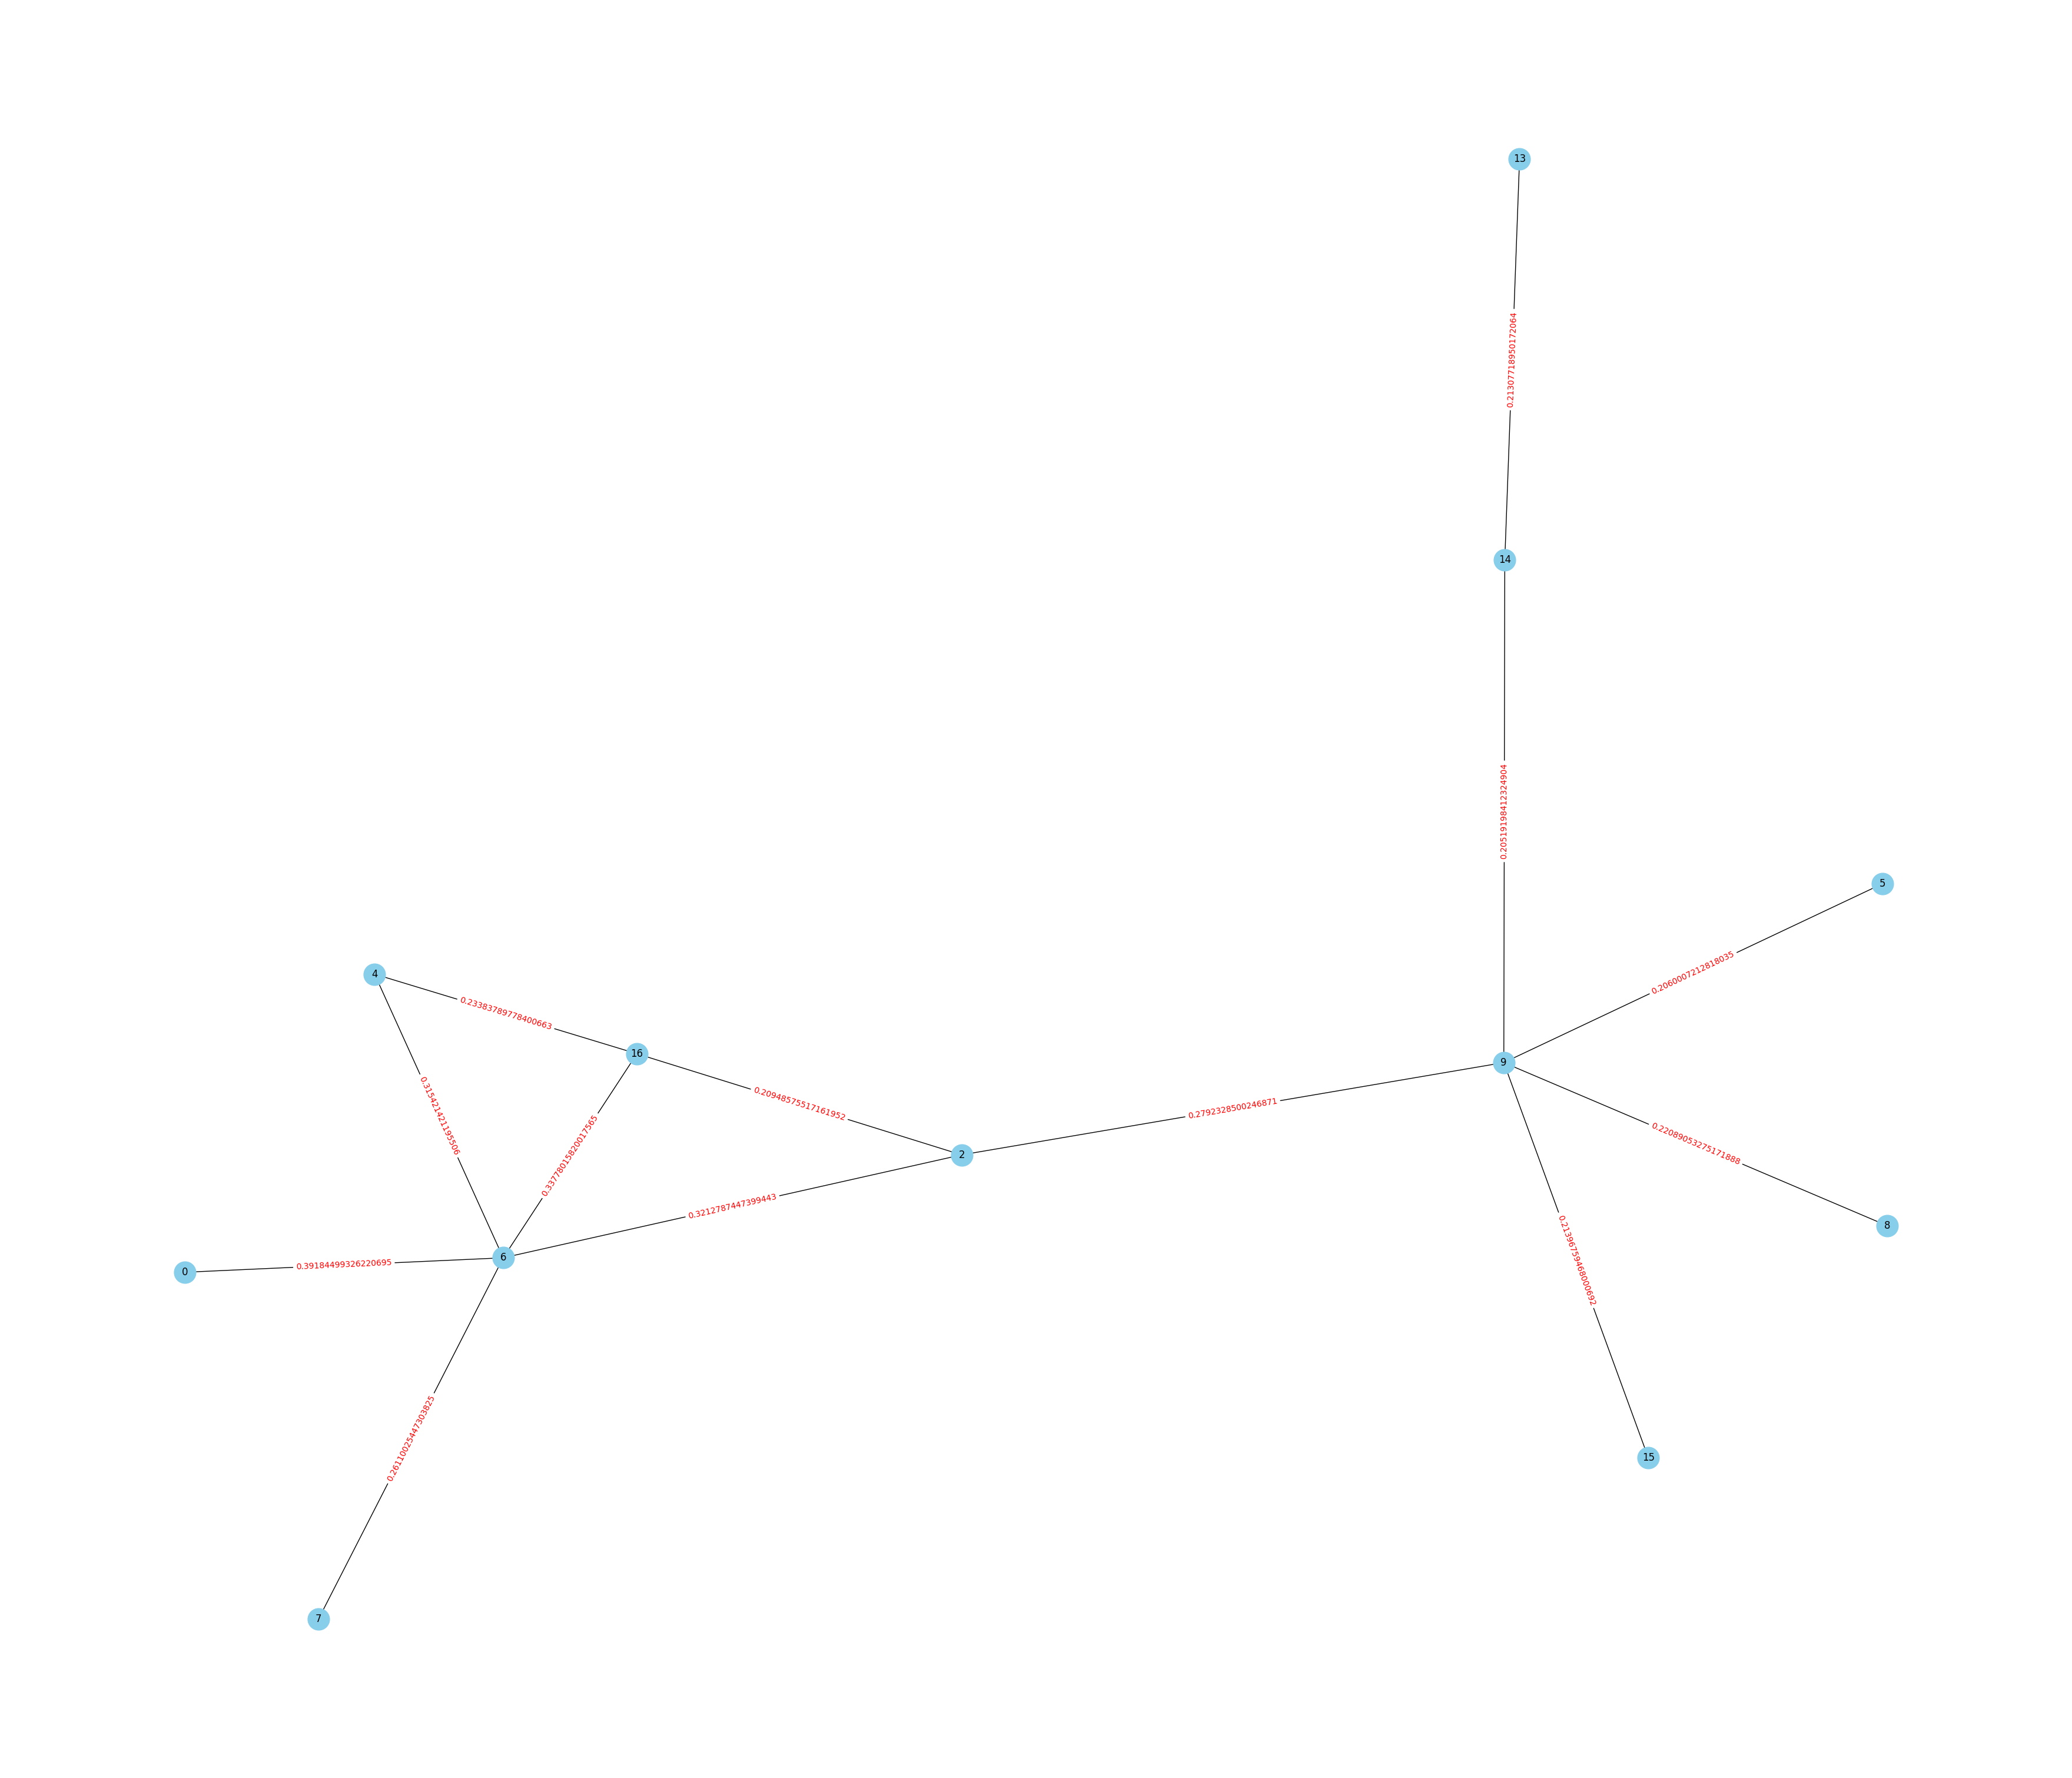

In [28]:
plot_graph(G)

## Peringkasan Semua Data

menggunakan fungsi `apply` dari Pandas untuk membuat ringkasan teks dari kolom 'Cleaning' dalam DataFrame `df` dan kemudian menyimpannya dalam kolom baru yang disebut 'Summary'. Inilah yang terjadi dalam kode tersebut:

1. Anda menggunakan `df.apply()` untuk menerapkan fungsi lambda ke setiap baris (row) dalam DataFrame `df`. Fungsi lambda ini mengambil satu baris sekaligus, yaitu nilai dalam kolom 'Cleaning' pada setiap baris, dan melakukan operasi berikut.

2. Dalam fungsi lambda, Anda memanggil fungsi `summarization` dengan parameter sebagai berikut:
   - `row['Cleaning']`: Ini adalah teks yang akan di-ringkaskan. Anda mengambil teks ini dari kolom 'Cleaning'.
   - `index=row.name+1`: Anda memberikan parameter 'index' ke fungsi `summarization` yang setara dengan nomor baris ditambah 1.
   - `k=7`: Anda meminta 7 kalimat dalam ringkasan.
   - `show_centrality=True`: Anda meminta untuk menampilkan nilai closeness centrality.
   
3. Hasil dari pemanggilan fungsi `summarization` adalah pasangan nilai yang terdiri dari teks ringkasan dan grafik jaringan yang mencerminkan hubungan kesamaan kosinus antara kalimat-kalimat dalam teks.

4. Anda mengambil nilai pertama (teks ringkasan) dari hasil pemanggilan fungsi `summarization` dengan `[0]` dan menyimpannya dalam kolom 'Summary' dalam DataFrame `df`. Ini akan mengisi setiap baris dengan ringkasan teks yang sesuai.

In [29]:
df["Summary"] = df.apply(lambda row : summarization(row['Tokenizing'], index=row.name+1, k=7, show_centrality=True)[0], axis=1)

Nilai Closeness Centrality Dokumen Ke - 1 : {0: 0.5588235294117647, 2: 0.6333333333333333, 3: 0.5, 4: 0.5135135135135135, 5: 0.5588235294117647, 6: 0.59375, 7: 0.5277777777777778, 16: 0.6333333333333333, 1: 0.3958333333333333, 17: 0.48717948717948717, 9: 0.5588235294117647, 13: 0.5428571428571428, 14: 0.59375, 11: 0.41304347826086957, 15: 0.4318181818181818, 19: 0.38, 8: 0.37254901960784315, 10: 0.48717948717948717, 12: 0.35185185185185186, 18: 0.48717948717948717}
Nilai Closeness Centrality Dokumen Ke - 2 : {0: 0.3712121212121212, 1: 0.5104166666666667, 2: 0.4537037037037037, 4: 0.4083333333333333, 8: 0.4083333333333333, 11: 0.2916666666666667, 12: 0.2916666666666667, 5: 0.2916666666666667, 6: 0.19047619047619047, 9: 0.19047619047619047, 10: 0.26666666666666666, 7: 0.14814814814814814, 13: 0.2222222222222222}
Nilai Closeness Centrality Dokumen Ke - 3 : {0: 0.16161616161616163, 2: 0.19047619047619047, 1: 0.19047619047619047, 3: 0.16494845360824742, 12: 0.2191780821917808, 14: 0.1882352

membuat DataFrame baru yang disebut `new_df` dengan memilih dua kolom dari DataFrame awal `df`, yaitu "Summary" dan "Category". Hasil dari eksekusi kode tersebut adalah DataFrame `new_df` yang hanya berisi kolom-kolom yang Anda pilih. Ini berguna untuk memusatkan perhatian pada informasi yang penting dalam analisis atau pemodelan data. `new_df` akan berisi ringkasan teks dan kategori berita dari DataFrame asli.

In [30]:
new_df = df[["Summary", "Category"]]
new_df

,Summary,Category
0,"hingga saat ini, menurut bbc, manusia sudah me...",Tech
1,ia marah dan menuntut pengembang aplikasi ai k...,Tech
2,saat ini kami membuat perubahan organisasi dan...,Tech
3,wilayah itu juga akan tetap dalam hatinya mesk...,Tech
4,bri mendapat pengakuan sebagai institusi keuan...,Tech
...,...,...
1495,ketegangan sangat terasa di sepanjang babak fi...,Entrepreneur
1496,"saat ini, gibrik menjadi mesin pengolah sampah...",Entrepreneur
1497,pameran mewah ini akan berlangsung dari 5 hing...,Entrepreneur
1498,"jakarta, cnbc indonesia sampoerna entrepreneu...",Entrepreneur


## Save Dataset Hasil Ringkasan

In [31]:
new_df.to_csv('Data Berita Hasil Ringkasan.csv')

## Modeling Dengan Dataset Ringkasan

### Modeling (Naive Bayes)

In [32]:
df["Summary"][0]

'hingga saat ini, menurut bbc, manusia sudah menemukan lebih dari 5.500 planet di galaksi yang sama dengan bumi. pengamat dari planet lain juga bisa menerka ada kehidupan di bumi dengan mengamati atmosfer bumi. jika alien di planet lain menggunakan metode yang sama dengan manusia di bumi, seharusnya mereka sudah lama tahu bahwa ada kehidupan cerdas di bumi. isaacson menambahkan, alien yang tinggal di sekitar yang bintang terdekat dari bumi sudah punya waktu untuk menerima dan mengirim sinyal balasan dalam 8 tahun ke depan. jakarta, cnbc indonesia  astronom yakin alien sudah tahu bahwa di bumi ada kehidupan umat manusia. cara astronom mencari alien beragam, mulai dari pemantauan sinyal kimia di atmosfer hingga memindai sinyal teknologi seperti gelombang radio. mereka dari zaman perang dunia membutuhkan sinyal yang lebih kuat karena radio yang digunakan oleh masyarakat saat itu tidak memiliki antena radio yang sensitif, kata howard isaacson dari uc berkeley dikutip dari futurism, pada se

#### Vectorizer X_Summary

In [33]:
vectorizer_summary = TfidfVectorizer()
X_summary = vectorizer_summary.fit_transform(df["Summary"]).toarray()
y = df["Category"]

#### Splitting Data

In [34]:
X_train_summary, X_test_summary, y_train_summary, y_test_summary = train_test_split(X_summary, y, test_size=0.3, random_state=42)

#### Modeling Naive Bayes

In [35]:
# Inisialisasi model Naive Bayes Gaussian
gnb_summary = GaussianNB()

# Melatih model menggunakan data latih
gnb_summary.fit(X_train_summary, y_train_summary)

# Membuat prediksi pada data uji
y_pred_gnb_summary = gnb_summary.predict(X_test_summary)

#### Accuracy

In [36]:
# Mengukur kinerja model dengan menghitung akurasi atau metrik lain yang relevan
accuracy = accuracy_score(y_test_summary, y_pred_gnb_summary)
print(f'Akurasi: {accuracy}')

Akurasi: 0.8488888888888889


#### Evaluasi

In [37]:
report = classification_report(y_test_summary, y_pred_gnb_summary)
print(f'Report Klasifikasi:\n{report}')

Report Klasifikasi:
              precision    recall  f1-score   support

Entrepreneur       0.90      0.82      0.86       161
        News       0.83      0.86      0.84       141
        Tech       0.82      0.87      0.84       148

    accuracy                           0.85       450
   macro avg       0.85      0.85      0.85       450
weighted avg       0.85      0.85      0.85       450



#### Confusion Matrix

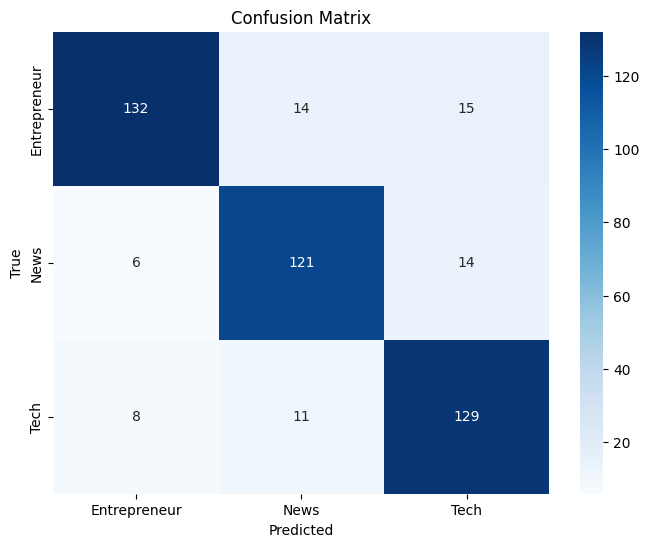

In [38]:
def plot_confusion_matrix(cm):
  # Membuat plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=gnb_summary.classes_, yticklabels=gnb_summary.classes_)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

cm = confusion_matrix(y_test_summary, y_pred_gnb_summary)
plot_confusion_matrix(cm)

#### Prediction

##### Data Baru dengan Peringkasan

In [73]:
new_data = ["Sebuah tim peneliti, yang dipimpin oleh mahasiswa doktoral Institute of Agricultural Engineering, University of Bonn, Jerman Sonja Hillemacher dan Dr. Inga Tiemann, telah melakukan penelitian ilmiah selama bertahun-tahun terhadap perilaku ayam di depan cermin. Ide bereksperimen dengan ayam datang dari para ilmuwan tersebut bersama guru besar Biopsikologi dari Departemen Biopsikologi di Universitas Ruhr, Onur Güntürkün. Filosofi penelitian ini bermula dari sebuah pertanyaan terkait 'Apakah hewan dapat mengenali dirinya sendiri?,' kata Sonja Hillemacher. Penelitian ini pun bertujuan untuk menjawab pertanyaan apakah ayam mampu mengenali diri mereka sendiri ketika berinteraksi dengan cermin. Metode Pendekatan Perilaku Hewan Penelitian ini mengadopsi metode yang telah umum digunakan dalam uji cermin, yang dikenal sebagai 'mark test'. Dalam tes ini, tanda berwarna ditempatkan di tubuh hewan yang hanya dapat dikenali oleh individu tersebut ketika ia melihat dirinya sendiri di cermin. Apabila hewan tersebut mulai memeriksa atau meraba area tubuhnya yang ditandai di depan cermin, itu menunjukkan bahwa hewan telah mengenali wujudnya sebagai dirinya sendiri. Namun, tes ini tidak selalu berhasil, di mana sebagian hewan yang diyakini sadar diri, tidak memperhatikan cermin. Mungkin, karena mereka merasa tidak nyaman dalam lingkungan percobaan 'buatan'? Penelitian ini mencoba mendekati eksperimen ini dengan mempertimbangkan perilaku alami ayam yang relevan secara ekologis. 'Beberapa ayam, terutama ayam jantan, memperingatkan sesamanya melalui panggilan khusus ketika ada predator -- seperti burung pemangsa atau rubah - - muncul,' kata Güntürkün. Sebaliknya jika ayam jago berhadapan dengan predatornya sendirian, biasanya mereka akan berdiam diri agar tidak menarik perhatian predator itu sendiri dan menjadi korban. 'Seruan peringatan adalah perilaku sempurna untuk diintegrasikan ke dalam tes kesadaran diri yang lebih relevan secara ekologis,' tambah biopsikolog tersebut. Uji Coba dengan Melepas Burung Pemangsa Pertama, penelitian ini memeriksa apakah ayam jantan benar-benar mengeluarkan panggilan alarm saat berhadapan dengan spesies dan tetap diam saat sendirian. Ilmuwan membangun tempat uji coba khusus yang memisahkan dua area di mana ayam jantan dapat melihat satu sama lain. Setelah itu, seekor burung pemangsa pun dilepaskan di langit-langit sebuah area. Dengan melibatkan 58 ekor ayam jantan, setiap ayamnya mengalami proses pengulangan penelitian sebanyak tiga kali untuk memvalidasi hasil statistik. Hasilnya pun menunjukkan bahwa ayam jantan mengeluarkan 77 panggilan alarm saat berhadapan dengan ayam jantan lain, tetapi hanya 17 panggilan ketika ayam jantan itu sendiri. Dengan begitu, ini menunjukkan bahwa sebagian besar ayam jantan sangat waspada saat menghadapi sesamanya ketika predator terlihat. Uji Coba dengan Cermin Langkah selanjutnya adalah menempatkan cermin di antara dua kompartemen, bukan di dalam kisi-kisi. Dalam proses penelitian ini, para peneliti menjalankannya tiga kali dengan masing-masing hewan. Hasilnya, hanya 25 panggilan alarm yang dikeluarkan selama 174 percobaan. Hasil ini mendukung gagasan bahwa ayam jantan mungkin mengenali dirinya sendiri dalam bayangan cerminnya. Namun, masih diperlukan penelitian lebih lanjut untuk memahami apakah hewan-hewan tersebut melihat bayangan diri mereka sebagai entitas yang sama atau sebagai binatang asing yang meniru perilaku mereka sendiri. Penelitian ini menunjukkan bahwa uji tanda cermin yang mengintegrasikan perilaku hewan ke dalam konteks yang lebih relevan secara ekologis memberikan hasil yang lebih dapat diandalkan."]
new_data_summary, G = summarization(tokenizer(new_data[0]), k=5)
new_data_summary

'dalam tes ini, tanda berwarna ditempatkan di tubuh hewan yang hanya dapat dikenali oleh individu tersebut ketika ia melihat dirinya sendiri di cermin. hasil ini mendukung gagasan bahwa ayam jantan mungkin mengenali dirinya sendiri dalam bayangan cerminnya. apabila hewan tersebut mulai memeriksa atau meraba area tubuhnya yang ditandai di depan cermin, itu menunjukkan bahwa hewan telah mengenali wujudnya sebagai dirinya sendiri. hasilnya pun menunjukkan bahwa ayam jantan mengeluarkan 77 panggilan alarm saat berhadapan dengan ayam jantan lain, tetapi hanya 17 panggilan ketika ayam jantan itu sendiri. penelitian ini pun bertujuan untuk menjawab pertanyaan apakah ayam mampu mengenali diri mereka sendiri ketika berinteraksi dengan cermin.'

##### TFIDF Hasil Peringkasan

In [41]:
tfidf_Xnew_summary = vectorizer_summary.transform([new_data_summary]).toarray()
tfidf_Xnew_summary

array([[0., 0., 0., ..., 0., 0., 0.]])

##### Prediksi Category

In [42]:
pred_gnb_summary = gnb_summary.predict(tfidf_Xnew_summary)
pred_gnb_summary[0]

'Entrepreneur'

### Save Model Naive Bayes Dengan Summary

In [43]:
joblib.dump(gnb_summary, 'modelNB.pkl')

['modelNB.pkl']

### Modeling Support Vector Machine (SVM)

#### Modeling Support Vector Machine

In [44]:
# Inisialisasi model Naive Bayes Gaussian
svm_summary = SVC()

# Melatih model menggunakan data latih
svm_summary.fit(X_train_summary, y_train_summary)

# Membuat prediksi pada data uji
y_pred_svm_summary = svm_summary.predict(X_test_summary)

#### Accuracy

In [45]:
# Mengukur kinerja model dengan menghitung akurasi atau metrik lain yang relevan
accuracy = accuracy_score(y_test_summary, y_pred_svm_summary)
print(f'Akurasi: {accuracy}')

Akurasi: 0.92


#### Evaluasi

In [46]:
report = classification_report(y_test_summary, y_pred_svm_summary)
print(f'Report Klasifikasi:\n{report}')

Report Klasifikasi:
              precision    recall  f1-score   support

Entrepreneur       0.90      0.93      0.91       161
        News       0.92      0.94      0.93       141
        Tech       0.94      0.89      0.92       148

    accuracy                           0.92       450
   macro avg       0.92      0.92      0.92       450
weighted avg       0.92      0.92      0.92       450



#### Confusion Matrix

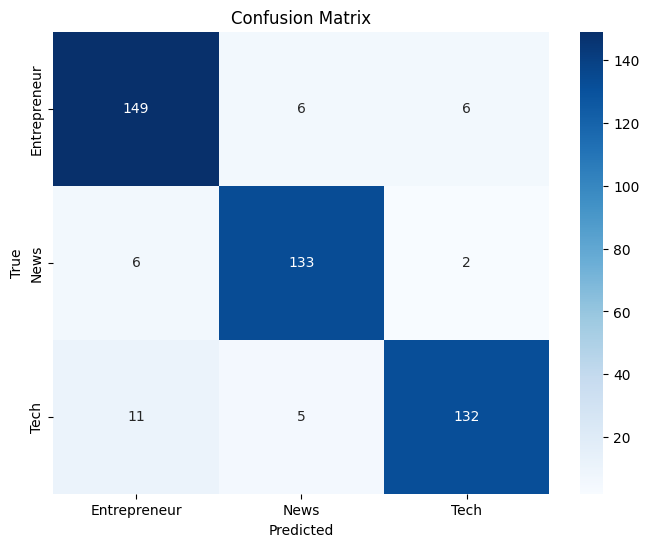

In [47]:
def plot_confusion_matrix(cm):
  # Membuat plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_summary.classes_, yticklabels=svm_summary.classes_)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

cm = confusion_matrix(y_test_summary, y_pred_svm_summary)
plot_confusion_matrix(cm)

#### Prediction

##### Data Baru dengan Peringkasan

In [74]:
new_data = ["Sebuah tim peneliti, yang dipimpin oleh mahasiswa doktoral Institute of Agricultural Engineering, University of Bonn, Jerman Sonja Hillemacher dan Dr. Inga Tiemann, telah melakukan penelitian ilmiah selama bertahun-tahun terhadap perilaku ayam di depan cermin. Ide bereksperimen dengan ayam datang dari para ilmuwan tersebut bersama guru besar Biopsikologi dari Departemen Biopsikologi di Universitas Ruhr, Onur Güntürkün. Filosofi penelitian ini bermula dari sebuah pertanyaan terkait 'Apakah hewan dapat mengenali dirinya sendiri?,' kata Sonja Hillemacher. Penelitian ini pun bertujuan untuk menjawab pertanyaan apakah ayam mampu mengenali diri mereka sendiri ketika berinteraksi dengan cermin. Metode Pendekatan Perilaku Hewan Penelitian ini mengadopsi metode yang telah umum digunakan dalam uji cermin, yang dikenal sebagai 'mark test'. Dalam tes ini, tanda berwarna ditempatkan di tubuh hewan yang hanya dapat dikenali oleh individu tersebut ketika ia melihat dirinya sendiri di cermin. Apabila hewan tersebut mulai memeriksa atau meraba area tubuhnya yang ditandai di depan cermin, itu menunjukkan bahwa hewan telah mengenali wujudnya sebagai dirinya sendiri. Namun, tes ini tidak selalu berhasil, di mana sebagian hewan yang diyakini sadar diri, tidak memperhatikan cermin. Mungkin, karena mereka merasa tidak nyaman dalam lingkungan percobaan 'buatan'? Penelitian ini mencoba mendekati eksperimen ini dengan mempertimbangkan perilaku alami ayam yang relevan secara ekologis. 'Beberapa ayam, terutama ayam jantan, memperingatkan sesamanya melalui panggilan khusus ketika ada predator -- seperti burung pemangsa atau rubah - - muncul,' kata Güntürkün. Sebaliknya jika ayam jago berhadapan dengan predatornya sendirian, biasanya mereka akan berdiam diri agar tidak menarik perhatian predator itu sendiri dan menjadi korban. 'Seruan peringatan adalah perilaku sempurna untuk diintegrasikan ke dalam tes kesadaran diri yang lebih relevan secara ekologis,' tambah biopsikolog tersebut. Uji Coba dengan Melepas Burung Pemangsa Pertama, penelitian ini memeriksa apakah ayam jantan benar-benar mengeluarkan panggilan alarm saat berhadapan dengan spesies dan tetap diam saat sendirian. Ilmuwan membangun tempat uji coba khusus yang memisahkan dua area di mana ayam jantan dapat melihat satu sama lain. Setelah itu, seekor burung pemangsa pun dilepaskan di langit-langit sebuah area. Dengan melibatkan 58 ekor ayam jantan, setiap ayamnya mengalami proses pengulangan penelitian sebanyak tiga kali untuk memvalidasi hasil statistik. Hasilnya pun menunjukkan bahwa ayam jantan mengeluarkan 77 panggilan alarm saat berhadapan dengan ayam jantan lain, tetapi hanya 17 panggilan ketika ayam jantan itu sendiri. Dengan begitu, ini menunjukkan bahwa sebagian besar ayam jantan sangat waspada saat menghadapi sesamanya ketika predator terlihat. Uji Coba dengan Cermin Langkah selanjutnya adalah menempatkan cermin di antara dua kompartemen, bukan di dalam kisi-kisi. Dalam proses penelitian ini, para peneliti menjalankannya tiga kali dengan masing-masing hewan. Hasilnya, hanya 25 panggilan alarm yang dikeluarkan selama 174 percobaan. Hasil ini mendukung gagasan bahwa ayam jantan mungkin mengenali dirinya sendiri dalam bayangan cerminnya. Namun, masih diperlukan penelitian lebih lanjut untuk memahami apakah hewan-hewan tersebut melihat bayangan diri mereka sebagai entitas yang sama atau sebagai binatang asing yang meniru perilaku mereka sendiri. Penelitian ini menunjukkan bahwa uji tanda cermin yang mengintegrasikan perilaku hewan ke dalam konteks yang lebih relevan secara ekologis memberikan hasil yang lebih dapat diandalkan."]
new_data_summary, G = summarization(tokenizer(new_data[0]), k=5)
new_data_summary

'dalam tes ini, tanda berwarna ditempatkan di tubuh hewan yang hanya dapat dikenali oleh individu tersebut ketika ia melihat dirinya sendiri di cermin. hasil ini mendukung gagasan bahwa ayam jantan mungkin mengenali dirinya sendiri dalam bayangan cerminnya. apabila hewan tersebut mulai memeriksa atau meraba area tubuhnya yang ditandai di depan cermin, itu menunjukkan bahwa hewan telah mengenali wujudnya sebagai dirinya sendiri. hasilnya pun menunjukkan bahwa ayam jantan mengeluarkan 77 panggilan alarm saat berhadapan dengan ayam jantan lain, tetapi hanya 17 panggilan ketika ayam jantan itu sendiri. penelitian ini pun bertujuan untuk menjawab pertanyaan apakah ayam mampu mengenali diri mereka sendiri ketika berinteraksi dengan cermin.'

##### TFIDF Hasil Peringkasan

In [49]:
tfidf_Xnew_summary = vectorizer_summary.transform([new_data_summary]).toarray()
tfidf_Xnew_summary

array([[0., 0., 0., ..., 0., 0., 0.]])

##### Prediksi Category

In [50]:
pred_svm_summary = svm_summary.predict(tfidf_Xnew_summary)
pred_svm_summary[0]

'Entrepreneur'

### Save Model SVM Dengan Summary

In [51]:
joblib.dump(svm_summary, 'modelSVM.pkl')

['modelSVM.pkl']

### Save Vectorizer Dengan Summary

In [52]:
joblib.dump(vectorizer_summary, 'vectorizer.pkl')

['vectorizer.pkl']

## Modeling Dengan Dataset Tanpa Ringkasan

### Modeling (Naive Bayes)

In [53]:
df["Artikel"][0]

'Jakarta, CNBC Indonesia - Astronom yakin alien sudah tahu bahwa di Bumi ada kehidupan umat manusia. Pasalnya, aktivitas manusia, sengaja ataupun tidak sudah banyak menyisakan tanda peradaban cerdas. Hingga saat ini, menurut BBC, manusia sudah menemukan lebih dari 5.500 planet di galaksi yang sama dengan Bumi. Astronom memperkirakan masih ada triliunan planet di luar galaksi Bima Sakti. Namun sampai sekarang, peneliti di Bumi belum menemukan bukti kehidupan cerdas di planet lain di antariksa. Cara astronom mencari alien beragam, mulai dari pemantauan sinyal kimia di atmosfer hingga memindai sinyal teknologi seperti gelombang radio. Jika alien di planet lain menggunakan metode yang sama dengan manusia di Bumi, seharusnya mereka sudah lama tahu bahwa ada kehidupan cerdas di Bumi. Tanda-tanda kehidupan di Bumi sudah tersiar lama ke seluruh penjuru galaksi. Bahkan, sinyal tersiar lebih intens dan luas pada 1900-an hingga era Perang Dunia II. "[Mereka dari zaman Perang Dunia] membutuhkan si

#### Vectorizer X_Summary

In [54]:
vectorizer = TfidfVectorizer()
X_summary = vectorizer.fit_transform(df["Artikel"]).toarray()
y = df["Category"]

#### Splitting Data

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_summary, y, test_size=0.3, random_state=42)

#### Modeling Naive Bayes

In [56]:
# Inisialisasi model Naive Bayes Gaussian
gnb = GaussianNB()

# Melatih model menggunakan data latih
gnb.fit(X_train, y_train)

# Membuat prediksi pada data uji
y_pred_gnb = gnb.predict(X_test)

#### Accuracy

In [57]:
# Mengukur kinerja model dengan menghitung akurasi atau metrik lain yang relevan
accuracy = accuracy_score(y_test, y_pred_gnb)
print(f'Akurasi: {accuracy}')

Akurasi: 0.8911111111111111


#### Evaluasi

In [58]:
report = classification_report(y_test, y_pred_gnb)
print(f'Report Klasifikasi:\n{report}')

Report Klasifikasi:
              precision    recall  f1-score   support

Entrepreneur       0.86      0.90      0.88       161
        News       0.88      0.91      0.90       141
        Tech       0.94      0.86      0.90       148

    accuracy                           0.89       450
   macro avg       0.89      0.89      0.89       450
weighted avg       0.89      0.89      0.89       450



#### Confusion Matrix

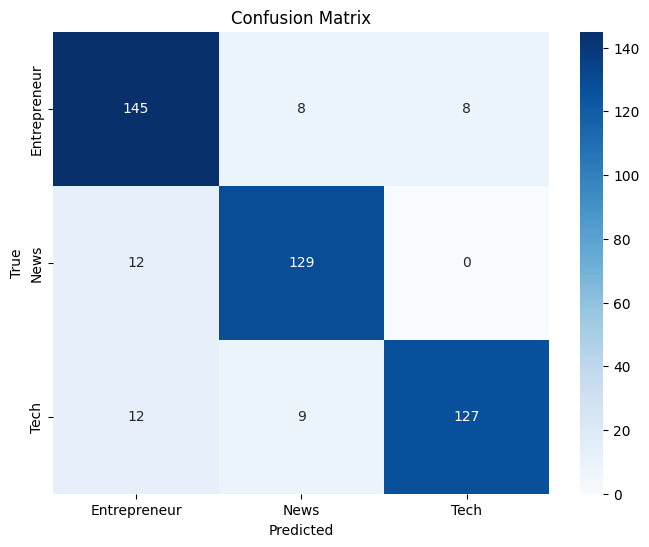

In [59]:
def plot_confusion_matrix(cm):
  # Membuat plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=gnb.classes_, yticklabels=gnb.classes_)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

cm = confusion_matrix(y_test, y_pred_gnb)
plot_confusion_matrix(cm)

#### Prediction

##### Data Baru tanpa Peringkasan

In [60]:
new_data = ["Sebuah tim peneliti, yang dipimpin oleh mahasiswa doktoral Institute of Agricultural Engineering, University of Bonn, Jerman Sonja Hillemacher dan Dr. Inga Tiemann, telah melakukan penelitian ilmiah selama bertahun-tahun terhadap perilaku ayam di depan cermin. Ide bereksperimen dengan ayam datang dari para ilmuwan tersebut bersama guru besar Biopsikologi dari Departemen Biopsikologi di Universitas Ruhr, Onur Güntürkün. Filosofi penelitian ini bermula dari sebuah pertanyaan terkait 'Apakah hewan dapat mengenali dirinya sendiri?,' kata Sonja Hillemacher. Penelitian ini pun bertujuan untuk menjawab pertanyaan apakah ayam mampu mengenali diri mereka sendiri ketika berinteraksi dengan cermin. Metode Pendekatan Perilaku Hewan Penelitian ini mengadopsi metode yang telah umum digunakan dalam uji cermin, yang dikenal sebagai 'mark test'. Dalam tes ini, tanda berwarna ditempatkan di tubuh hewan yang hanya dapat dikenali oleh individu tersebut ketika ia melihat dirinya sendiri di cermin. Apabila hewan tersebut mulai memeriksa atau meraba area tubuhnya yang ditandai di depan cermin, itu menunjukkan bahwa hewan telah mengenali wujudnya sebagai dirinya sendiri. Namun, tes ini tidak selalu berhasil, di mana sebagian hewan yang diyakini sadar diri, tidak memperhatikan cermin. Mungkin, karena mereka merasa tidak nyaman dalam lingkungan percobaan 'buatan'? Penelitian ini mencoba mendekati eksperimen ini dengan mempertimbangkan perilaku alami ayam yang relevan secara ekologis. 'Beberapa ayam, terutama ayam jantan, memperingatkan sesamanya melalui panggilan khusus ketika ada predator -- seperti burung pemangsa atau rubah - - muncul,' kata Güntürkün. Sebaliknya jika ayam jago berhadapan dengan predatornya sendirian, biasanya mereka akan berdiam diri agar tidak menarik perhatian predator itu sendiri dan menjadi korban. 'Seruan peringatan adalah perilaku sempurna untuk diintegrasikan ke dalam tes kesadaran diri yang lebih relevan secara ekologis,' tambah biopsikolog tersebut. Uji Coba dengan Melepas Burung Pemangsa Pertama, penelitian ini memeriksa apakah ayam jantan benar-benar mengeluarkan panggilan alarm saat berhadapan dengan spesies dan tetap diam saat sendirian. Ilmuwan membangun tempat uji coba khusus yang memisahkan dua area di mana ayam jantan dapat melihat satu sama lain. Setelah itu, seekor burung pemangsa pun dilepaskan di langit-langit sebuah area. Dengan melibatkan 58 ekor ayam jantan, setiap ayamnya mengalami proses pengulangan penelitian sebanyak tiga kali untuk memvalidasi hasil statistik. Hasilnya pun menunjukkan bahwa ayam jantan mengeluarkan 77 panggilan alarm saat berhadapan dengan ayam jantan lain, tetapi hanya 17 panggilan ketika ayam jantan itu sendiri. Dengan begitu, ini menunjukkan bahwa sebagian besar ayam jantan sangat waspada saat menghadapi sesamanya ketika predator terlihat. Uji Coba dengan Cermin Langkah selanjutnya adalah menempatkan cermin di antara dua kompartemen, bukan di dalam kisi-kisi. Dalam proses penelitian ini, para peneliti menjalankannya tiga kali dengan masing-masing hewan. Hasilnya, hanya 25 panggilan alarm yang dikeluarkan selama 174 percobaan. Hasil ini mendukung gagasan bahwa ayam jantan mungkin mengenali dirinya sendiri dalam bayangan cerminnya. Namun, masih diperlukan penelitian lebih lanjut untuk memahami apakah hewan-hewan tersebut melihat bayangan diri mereka sebagai entitas yang sama atau sebagai binatang asing yang meniru perilaku mereka sendiri. Penelitian ini menunjukkan bahwa uji tanda cermin yang mengintegrasikan perilaku hewan ke dalam konteks yang lebih relevan secara ekologis memberikan hasil yang lebih dapat diandalkan."]

##### TFIDF Hasil Peringkasan

In [61]:
tfidf_Xnew_summary = vectorizer.transform(new_data).toarray()
tfidf_Xnew_summary

array([[0., 0., 0., ..., 0., 0., 0.]])

##### Prediksi Category

In [62]:
pred_gnb = gnb.predict(tfidf_Xnew_summary)
pred_gnb[0]

'Entrepreneur'

### Save Model Naive Bayes

In [63]:
joblib.dump(gnb, 'modelNB.pkl')

['modelNB.pkl']

### Modeling Support Vector Machine (SVM)

#### Modeling Support Vector Machine

In [64]:
# Inisialisasi model Naive Bayes Gaussian
svm = SVC()

# Melatih model menggunakan data latih
svm.fit(X_train, y_train)

# Membuat prediksi pada data uji
y_pred_svm = svm.predict(X_test)

#### Accuracy

In [65]:
# Mengukur kinerja model dengan menghitung akurasi atau metrik lain yang relevan
accuracy = accuracy_score(y_test, y_pred_svm)
print(f'Akurasi: {accuracy}')

Akurasi: 0.9488888888888889


#### Evaluasi

In [66]:
report = classification_report(y_test, y_pred_svm)
print(f'Report Klasifikasi:\n{report}')

Report Klasifikasi:
              precision    recall  f1-score   support

Entrepreneur       0.92      0.96      0.94       161
        News       0.96      0.96      0.96       141
        Tech       0.97      0.92      0.94       148

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



#### Confusion Matrix

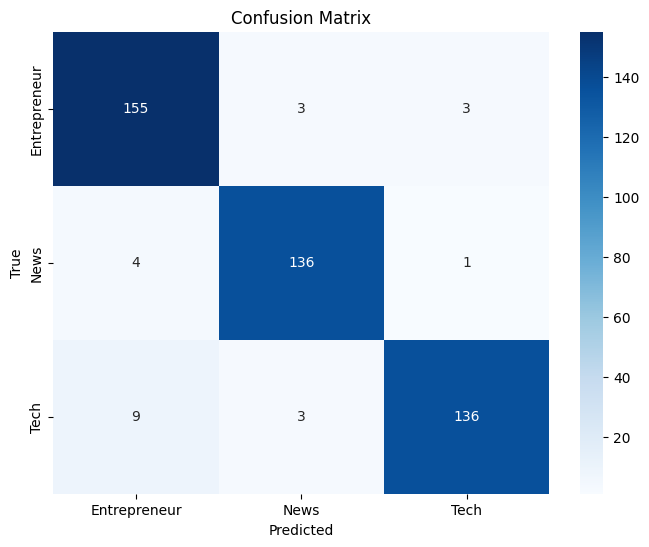

In [67]:
def plot_confusion_matrix(cm):
  # Membuat plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm.classes_, yticklabels=svm.classes_)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

cm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cm)

#### Prediction

##### Data Baru dengan Peringkasan

In [68]:
new_data = ["Sebuah tim peneliti, yang dipimpin oleh mahasiswa doktoral Institute of Agricultural Engineering, University of Bonn, Jerman Sonja Hillemacher dan Dr. Inga Tiemann, telah melakukan penelitian ilmiah selama bertahun-tahun terhadap perilaku ayam di depan cermin. Ide bereksperimen dengan ayam datang dari para ilmuwan tersebut bersama guru besar Biopsikologi dari Departemen Biopsikologi di Universitas Ruhr, Onur Güntürkün. Filosofi penelitian ini bermula dari sebuah pertanyaan terkait 'Apakah hewan dapat mengenali dirinya sendiri?,' kata Sonja Hillemacher. Penelitian ini pun bertujuan untuk menjawab pertanyaan apakah ayam mampu mengenali diri mereka sendiri ketika berinteraksi dengan cermin. Metode Pendekatan Perilaku Hewan Penelitian ini mengadopsi metode yang telah umum digunakan dalam uji cermin, yang dikenal sebagai 'mark test'. Dalam tes ini, tanda berwarna ditempatkan di tubuh hewan yang hanya dapat dikenali oleh individu tersebut ketika ia melihat dirinya sendiri di cermin. Apabila hewan tersebut mulai memeriksa atau meraba area tubuhnya yang ditandai di depan cermin, itu menunjukkan bahwa hewan telah mengenali wujudnya sebagai dirinya sendiri. Namun, tes ini tidak selalu berhasil, di mana sebagian hewan yang diyakini sadar diri, tidak memperhatikan cermin. Mungkin, karena mereka merasa tidak nyaman dalam lingkungan percobaan 'buatan'? Penelitian ini mencoba mendekati eksperimen ini dengan mempertimbangkan perilaku alami ayam yang relevan secara ekologis. 'Beberapa ayam, terutama ayam jantan, memperingatkan sesamanya melalui panggilan khusus ketika ada predator -- seperti burung pemangsa atau rubah - - muncul,' kata Güntürkün. Sebaliknya jika ayam jago berhadapan dengan predatornya sendirian, biasanya mereka akan berdiam diri agar tidak menarik perhatian predator itu sendiri dan menjadi korban. 'Seruan peringatan adalah perilaku sempurna untuk diintegrasikan ke dalam tes kesadaran diri yang lebih relevan secara ekologis,' tambah biopsikolog tersebut. Uji Coba dengan Melepas Burung Pemangsa Pertama, penelitian ini memeriksa apakah ayam jantan benar-benar mengeluarkan panggilan alarm saat berhadapan dengan spesies dan tetap diam saat sendirian. Ilmuwan membangun tempat uji coba khusus yang memisahkan dua area di mana ayam jantan dapat melihat satu sama lain. Setelah itu, seekor burung pemangsa pun dilepaskan di langit-langit sebuah area. Dengan melibatkan 58 ekor ayam jantan, setiap ayamnya mengalami proses pengulangan penelitian sebanyak tiga kali untuk memvalidasi hasil statistik. Hasilnya pun menunjukkan bahwa ayam jantan mengeluarkan 77 panggilan alarm saat berhadapan dengan ayam jantan lain, tetapi hanya 17 panggilan ketika ayam jantan itu sendiri. Dengan begitu, ini menunjukkan bahwa sebagian besar ayam jantan sangat waspada saat menghadapi sesamanya ketika predator terlihat. Uji Coba dengan Cermin Langkah selanjutnya adalah menempatkan cermin di antara dua kompartemen, bukan di dalam kisi-kisi. Dalam proses penelitian ini, para peneliti menjalankannya tiga kali dengan masing-masing hewan. Hasilnya, hanya 25 panggilan alarm yang dikeluarkan selama 174 percobaan. Hasil ini mendukung gagasan bahwa ayam jantan mungkin mengenali dirinya sendiri dalam bayangan cerminnya. Namun, masih diperlukan penelitian lebih lanjut untuk memahami apakah hewan-hewan tersebut melihat bayangan diri mereka sebagai entitas yang sama atau sebagai binatang asing yang meniru perilaku mereka sendiri. Penelitian ini menunjukkan bahwa uji tanda cermin yang mengintegrasikan perilaku hewan ke dalam konteks yang lebih relevan secara ekologis memberikan hasil yang lebih dapat diandalkan."]

##### TFIDF Hasil Peringkasan

In [69]:
tfidf_Xnew_summary = vectorizer.transform(new_data).toarray()
tfidf_Xnew_summary

array([[0., 0., 0., ..., 0., 0., 0.]])

##### Prediksi Category

In [70]:
pred_svm = svm.predict(tfidf_Xnew_summary)
pred_svm[0]

'Entrepreneur'

### Save Model SVM Tanpa Summary

In [71]:
joblib.dump(svm, 'modelSVM.pkl')

['modelSVM.pkl']

### Save Vectorizer Tanpa Summary

In [72]:
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']